#Install😎

In [1]:
!pip install torchmetrics

#Imports👽

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader,TensorDataset,random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import scipy
import pylab
import statsmodels.tsa.stattools as sts
import pandas as pd
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm
import glob
import os

from datetime import datetime,timedelta

#Download Data✨

In [22]:
api_key = 'e61479fbc59d62f40c959bd6021e9df48b79c324'

In [23]:
end = datetime.now()
start = end - timedelta(days=365*2)
start_date = start.replace(hour=0, minute=0, second=0, microsecond=0)
end_date = end.replace(hour=23, minute=59, second=59, microsecond=999999)

In [24]:
ticker = 'EURJPY'
interval = '1hour'

url = f'https://api.tiingo.com/tiingo/fx/{ticker}/prices?startDate={start_date}&endDate={end_date}&resampleFreq={interval}&token={api_key}'

In [25]:
response = requests.get(url)

In [26]:
if response.status_code == 200:
    data = response.json()
    df = pd.json_normalize(data)

    df.to_excel('stock_data.xlsx', index=False)
    print('Data saved successfully.')
else:
    print("Error receiving data")

Data saved successfully.


In [27]:
df.head(10)

,date,ticker,open,high,low,close
0,2022-05-19T00:00:00.000Z,eurjpy,133.9875,134.8415,133.9465,134.6370
1,2022-05-19T01:00:00.000Z,eurjpy,134.6450,134.9070,134.5905,134.7190
2,2022-05-19T02:00:00.000Z,eurjpy,134.7195,135.1620,134.6815,135.0895
3,2022-05-19T03:00:00.000Z,eurjpy,135.0890,135.2725,135.0840,135.1930
4,2022-05-19T04:00:00.000Z,eurjpy,135.1920,135.4630,135.1820,135.2375
5,2022-05-19T05:00:00.000Z,eurjpy,135.2370,135.3090,134.8580,134.8640
6,2022-05-19T06:00:00.000Z,eurjpy,134.8630,134.9860,134.6090,134.7335
7,2022-05-19T07:00:00.000Z,eurjpy,134.7330,134.7400,134.1340,134.5560
8,2022-05-19T08:00:00.000Z,eurjpy,134.5440,134.5460,134.1120,134.2065
9,2022-05-19T09:00:00.000Z,eurjpy,134.2055,134.3475,133.9275,133.9960


In [28]:
df=df.drop('ticker',axis=1)

In [29]:
df= pd.DataFrame(df)
# Convert the 'date' column to a datetime format

df['date']=pd.to_datetime(df['date'])
df

,date,open,high,low,close
0,2022-05-19 00:00:00+00:00,133.9875,134.8415,133.9465,134.6370
1,2022-05-19 01:00:00+00:00,134.6450,134.9070,134.5905,134.7190
2,2022-05-19 02:00:00+00:00,134.7195,135.1620,134.6815,135.0895
3,2022-05-19 03:00:00+00:00,135.0890,135.2725,135.0840,135.1930
4,2022-05-19 04:00:00+00:00,135.1920,135.4630,135.1820,135.2375
...,...,...,...,...,...
6956,2023-07-07 16:00:00+00:00,155.9160,156.0040,155.8510,155.9190
6957,2023-07-07 17:00:00+00:00,155.9185,155.9965,155.8940,155.9050
6958,2023-07-07 18:00:00+00:00,155.9060,155.9360,155.8710,155.8805
6959,2023-07-07 19:00:00+00:00,155.8800,155.9150,155.8135,155.8715


In [30]:
df['date'] = df['date'].dt.strftime('%d-%m-%Y %H:%M:%S')
df.set_index('date',inplace=True)


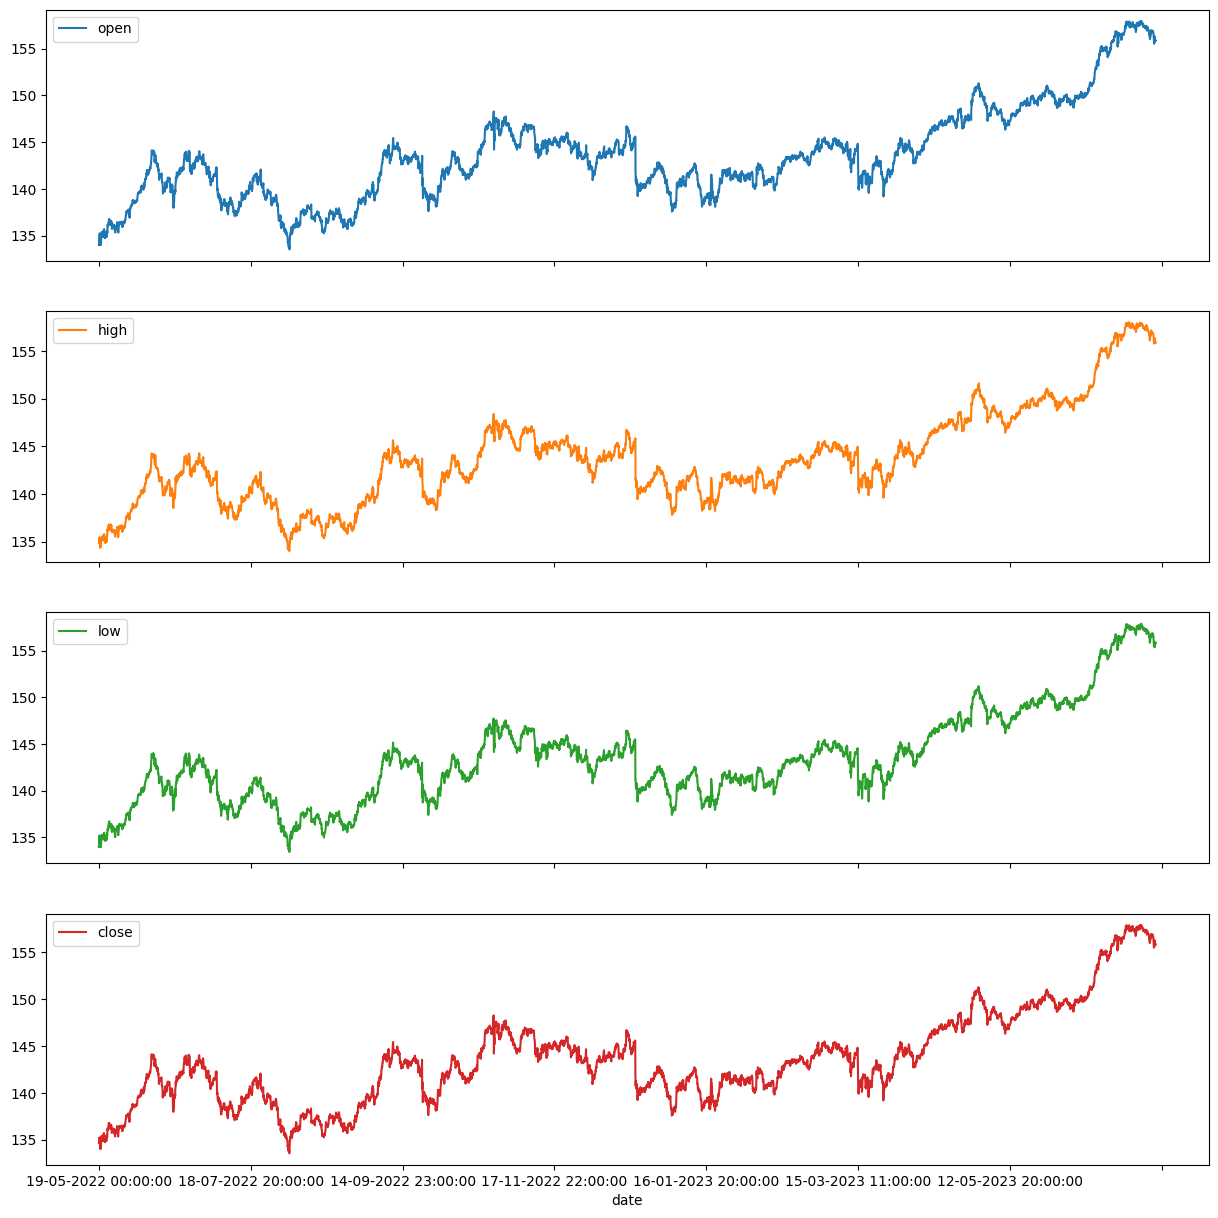

In [31]:
df.plot(figsize=(15,15),subplots=True)

plt.show()

#Split🎫

In [32]:
# def create_sequences(data, seq_length):
#   xs = []
#   ys = []
#   for col in data.columns:
#     x = []
#     y = []
#     for i in range(len(data[col])-seq_length):
#       x.append(data[col][i:i+seq_length])
#       y.append(data[col][i+seq_length])
#     xs.append(x)
#     ys.append(y)
#   return np.array(xs), np.array(ys)

In [33]:
# x, y = create_sequences(df, 5)

In [34]:
# x = x.swapaxes(1, 0).swapaxes(2, 1)
# y = y.swapaxes(0, 1)

In [35]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [36]:
lag=5
train_split = int(len(df)*0.8)
train_split

5568

In [37]:
df=np.array(df)

In [38]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [39]:
n_step = 1
past_history = lag
n_step= 1
STEP = 1

In [40]:
x_train, y_train = multivariate_data(df, df[:, 0], 0,
                                                   train_split, past_history,
                                                   n_step, STEP,
                                                   single_step=True)
x_test, y_test = multivariate_data(df, df[:, 0],
                                               train_split, None, past_history,
                                               n_step, STEP,
                                               single_step=True)

#Preprocessing

In [41]:
scalers = {}
for i in range(x_train.shape[2]):
    scalers [i]= MinMaxScaler(feature_range=(0,1))
    x_train[:, :, i] = scalers[i].fit_transform(x_train[:, :, i])

for i in range(x_test.shape[2]):
    x_test[:, :, i] = scalers[i].transform(x_test[:, :, i])

In [42]:
scalers_test= MinMaxScaler(feature_range=(0,1))
y_train = scalers_test.fit_transform(y_train.reshape(-1,1))
y_test = scalers_test.transform(y_test.reshape(-1,1))

#Convert to tensor🎡

In [43]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

#Data Loader🧵

In [48]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [49]:
train_loader = DataLoader(train_set, 32, False)
test_loader = DataLoader(test_set, 64, False)

In [50]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([32, 5, 4])
torch.Size([32, 1])


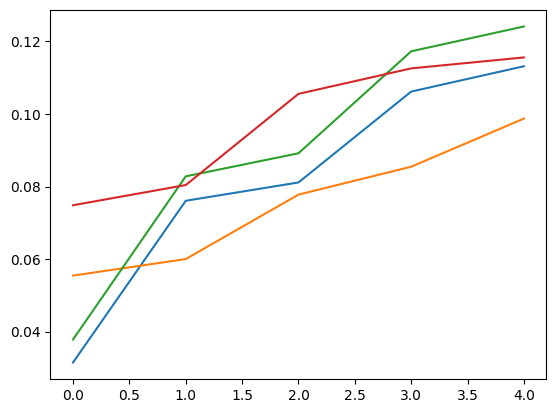

In [51]:
plt.plot(x[0])

#Device

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#Functions

In [53]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [54]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [55]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss_valid.update(loss.item())
  return loss_valid.avg

#Model🧩

In [79]:
class RNNModel(nn.Module):
  def __init__(self, rnn, input_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.hidden_size = hidden_size
    self.rnn = rnn(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers = num_layers,
                   dropout=dropout)
    self.fc = nn.LazyLinear(1)

  def forward(self, x):
    outputs, h = self.rnn(x)
    y = self.fc(outputs[:, -1])
    return y

#Forward check

In [81]:
model = RNNModel(nn.RNN, 4, 32, 1, 0.)
x_batch, y_batch = next(iter(train_loader))
model(x_batch).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([32, 1])

In [82]:
y_batch.shape

torch.Size([32, 1])

#Backward Check

In [83]:
miniset, _ = random_split(train_set, (100, len(train_set)-100))
miniloader = DataLoader(miniset, 10)

In [84]:
model = RNNModel(nn.RNN, 4, 32, 1, 0.)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [85]:
num_epochs = 100

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, miniloader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 119.71batch/s, loss=0.00027]


#TRAIN🎯

In [86]:
model = RNNModel(nn.LSTM, 4, 32,1, 0.3)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [87]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [88]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
loss_fn = nn.MSELoss()

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, 'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1


Epoch 0: 100%|██████████| 174/174 [00:01<00:00, 113.56batch/s, loss=0.000369]


Valid: Loss = 0.001552
Model Saved!



Epoch 1: 100%|██████████| 174/174 [00:01<00:00, 110.26batch/s, loss=0.000367]


Valid: Loss = 0.001533
Model Saved!



Epoch 2: 100%|██████████| 174/174 [00:01<00:00, 112.79batch/s, loss=0.000365]


Valid: Loss = 0.001515
Model Saved!



Epoch 3: 100%|██████████| 174/174 [00:01<00:00, 101.25batch/s, loss=0.000363]


Valid: Loss = 0.001497
Model Saved!



Epoch 4: 100%|██████████| 174/174 [00:01<00:00, 104.01batch/s, loss=0.000361]


Valid: Loss = 0.00148
Model Saved!



Epoch 5: 100%|██████████| 174/174 [00:01<00:00, 92.87batch/s, loss=0.000359]


Valid: Loss = 0.001464
Model Saved!



Epoch 6: 100%|██████████| 174/174 [00:01<00:00, 99.52batch/s, loss=0.000358]


Valid: Loss = 0.001449
Model Saved!



Epoch 7: 100%|██████████| 174/174 [00:01<00:00, 97.57batch/s, loss=0.000356] 


Valid: Loss = 0.001434
Model Saved!



Epoch 8: 100%|██████████| 174/174 [00:01<00:00, 107.79batch/s, loss=0.000354]


Valid: Loss = 0.00142
Model Saved!



Epoch 9: 100%|██████████| 174/174 [00:01<00:00, 113.16batch/s, loss=0.000353]


Valid: Loss = 0.001406
Model Saved!



Epoch 10: 100%|██████████| 174/174 [00:01<00:00, 101.71batch/s, loss=0.000352]


Valid: Loss = 0.001393
Model Saved!



Epoch 11: 100%|██████████| 174/174 [00:01<00:00, 96.65batch/s, loss=0.00035]


Valid: Loss = 0.00138
Model Saved!



Epoch 12: 100%|██████████| 174/174 [00:01<00:00, 90.75batch/s, loss=0.000349]


Valid: Loss = 0.001368
Model Saved!



Epoch 13: 100%|██████████| 174/174 [00:01<00:00, 94.12batch/s, loss=0.000348] 


Valid: Loss = 0.001356
Model Saved!



Epoch 14:  82%|████████▏ | 143/174 [00:01<00:00, 90.04batch/s, loss=0.000341]

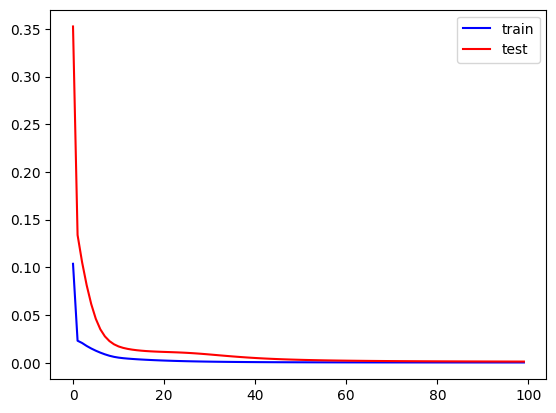

In [94]:
plt.plot(range(epoch_counter), loss_train_hist, '-b', label='train')
plt.plot(range(epoch_counter), loss_valid_hist, '-r', label='test')
plt.legend()
plt.show()

#Test

In [95]:
preds = model(x_test)

In [96]:
predict = scalers_test.inverse_transform(preds.detach().numpy())

y_test_inv = scalers_test.inverse_transform(y_test)

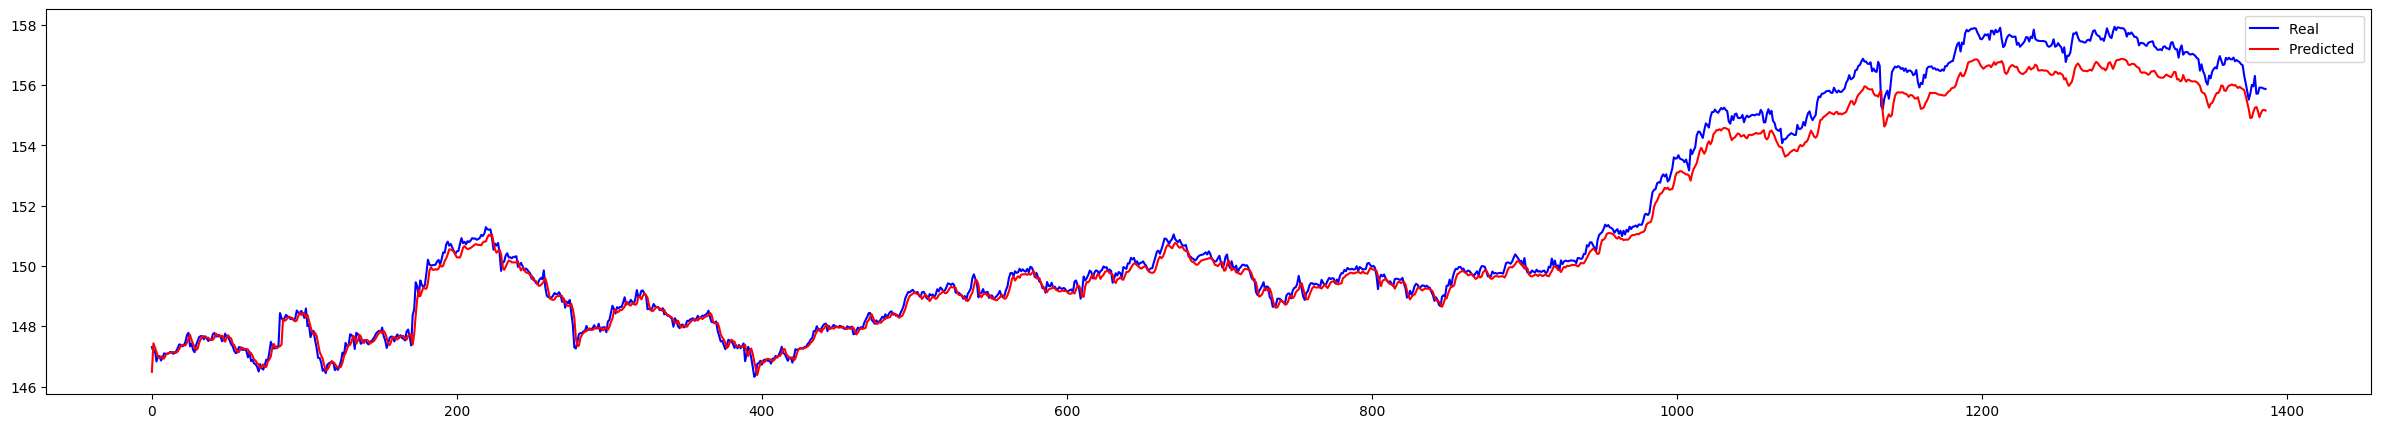

In [97]:
fig = plt.figure(figsize = (30,5))
plt.plot(y_test_inv, color='b', label='Real ')
plt.plot(predict, color='r', label='Predicted ')
plt.legend()
plt.show()

In [102]:
end = datetime.now()
start = end - timedelta(days=1)
start_date = start.replace(hour=0, minute=0, second=0, microsecond=0)
end_date = end.replace(hour=23, minute=59, second=59, microsecond=999999)

ticker = 'EURJPY'
interval = '1hour'

url = f'https://api.tiingo.com/tiingo/fx/{ticker}/prices?startDate={start_date}&endDate={end_date}&resampleFreq={interval}&token={api_key}'

In [103]:
response = requests.get(url)

In [104]:
if response.status_code == 200:
    data = response.json()
    df = pd.json_normalize(data)

    df.to_excel('test_data.xlsx', index=False)
    print('Data saved successfully.')
else:
    print("Error receiving data")

Data saved successfully.


In [106]:
df= pd.DataFrame(df)
# Convert the 'date' column to a datetime format

df['date']=pd.to_datetime(df['date'])
df

,date,ticker,open,high,low,close
0,2024-05-17 00:00:00+00:00,eurjpy,168.8865,168.9775,168.7830,168.8600
1,2024-05-17 01:00:00+00:00,eurjpy,168.8620,169.2790,168.8400,169.2140
2,2024-05-17 02:00:00+00:00,eurjpy,169.2160,169.2615,169.1470,169.2395
3,2024-05-17 03:00:00+00:00,eurjpy,169.2390,169.2875,169.1655,169.1800
4,2024-05-17 04:00:00+00:00,eurjpy,169.1795,169.2440,169.0985,169.1435
5,2024-05-17 05:00:00+00:00,eurjpy,169.1440,169.2250,169.1250,169.2200
6,2024-05-17 06:00:00+00:00,eurjpy,169.2190,169.2680,169.0085,169.0770
7,2024-05-17 07:00:00+00:00,eurjpy,169.0820,169.2795,169.0690,169.2070
8,2024-05-17 08:00:00+00:00,eurjpy,169.2080,169.2255,169.0090,169.0310
9,2024-05-17 09:00:00+00:00,eurjpy,169.0305,169.0880,168.9330,169.0025


In [107]:
df = df.drop('ticker', axis=1)

In [108]:
df['date'] = df['date'].dt.strftime('%d-%m-%Y %H:%M:%S')
df.set_index('date',inplace=True)

In [119]:
df = df.

,open,high,low,close
date,,,,
17-05-2024 00:00:00,168.8865,168.9775,168.7830,168.8600
17-05-2024 01:00:00,168.8620,169.2790,168.8400,169.2140
17-05-2024 02:00:00,169.2160,169.2615,169.1470,169.2395
17-05-2024 03:00:00,169.2390,169.2875,169.1655,169.1800
17-05-2024 04:00:00,169.1795,169.2440,169.0985,169.1435
17-05-2024 05:00:00,169.1440,169.2250,169.1250,169.2200
17-05-2024 06:00:00,169.2190,169.2680,169.0085,169.0770
17-05-2024 07:00:00,169.0820,169.2795,169.0690,169.2070
17-05-2024 08:00:00,169.2080,169.2255,169.0090,169.0310


In [120]:
df=np.array(df)

In [135]:
def multivariate_test(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [144]:
x_t, y_t = multivariate_test(df, df[:, 0], 0,
                             20, past_history,
                             n_step, STEP,
                             single_step=True)

In [140]:
x_t.shape

(20, 5, 4)

In [145]:
for i in range(x_t.shape[2]):
    x_t[:, :, i] = scalers[i].transform(x_t[:, :, i])

In [146]:
x_t = torch.FloatTensor(x_t)
y_t = torch.FloatTensor(y_t)

In [147]:
pred = model(x_t)

In [151]:
pred = scalers_test.inverse_transform(pred.detach().numpy())

In [152]:
y_t

tensor([168.8620, 169.2160, 169.2390, 169.1795, 169.1440, 169.2190, 169.0820,
        169.2080, 169.0305, 169.0030, 168.9060, 169.0015, 168.9250, 169.0640,
        169.0260, 169.0900, 169.1440, 169.2660, 169.3110, 169.2615])

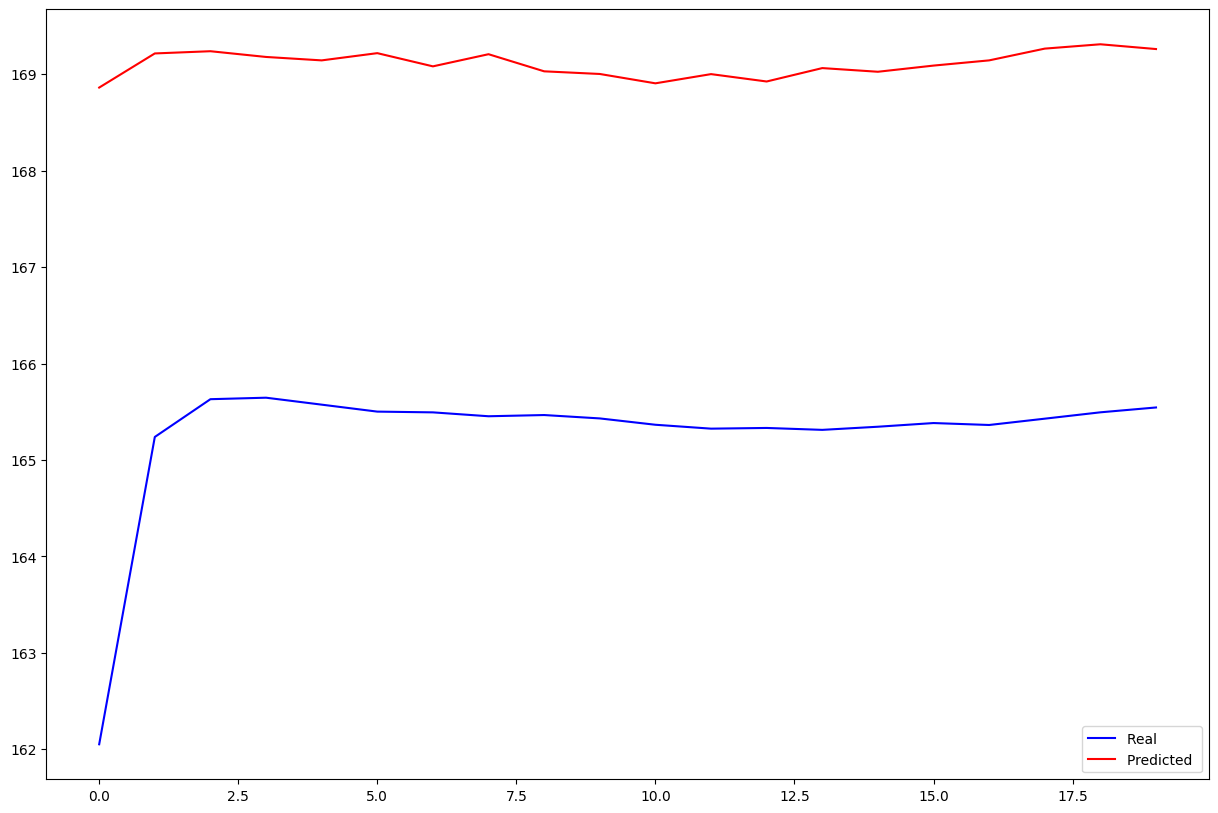

In [153]:
fig = plt.figure(figsize = (15,10))
plt.plot(pred, color='b', label='Real ')
plt.plot(y_t, color='r', label='Predicted ')
plt.legend()